# Central RL control notebook

In [2]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from IPython.display import display,clear_output
import pandas as pd
import torch

Time span constants

In [3]:
YEAR = 31579200
MONTH = 2570400
WEEK = 604800
DAY = 86400
HOUR = 3600
MINUTE = 60

### Generate Microgrids

In [5]:
env = mg.MicrogridGenerator()
env.generate_microgrid(verbose= False, minute= True, grid_type = 'disaster')
print('Next Microgrid')
env.generate_microgrid(verbose = False, minute = True, grid_type = 'weak')



Next Microgrid


In [6]:
env.print_mg_parameters()

,load,cost_loss_load,cost_overgeneration,cost_co2,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,grid_weak,grid_power_import,grid_power_export,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost,genset_co2
0,960,10,1,0.1,969.60,0.2,430,430,1718,0.9,0.2,1,0.02,disaster,1920.0,1920.0,3,7.877435,0.075405,0.015313,1067,0.05,0.9,0.4,2
1,45138,10,1,0.1,43332.48,0.2,13950,13950,55797,0.9,0.2,1,0.02,NaN,NaN,NaN,3,3.185501,0.050186,0.041337,50154,0.05,0.9,0.4,2


In [7]:
print(env.nb_microgrids)
mg0 = env.microgrids[0]
mg1 = env.microgrids[1]
print(mg1._load_ts)

2
                               0
2015-01-01 00:00:00  7182.004880
2015-01-01 00:00:01  7181.969090
2015-01-01 00:00:02  7181.933300
2015-01-01 00:00:03  7181.897510
2015-01-01 00:00:04  7181.861720
...                          ...
2015-12-31 22:59:56  6974.919089
2015-12-31 22:59:57  6974.734218
2015-12-31 22:59:58  6974.549347
2015-12-31 22:59:59  6974.364476
2015-12-31 23:00:00  6974.179605

[31532401 rows x 1 columns]


31532401


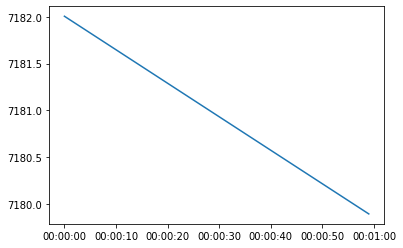

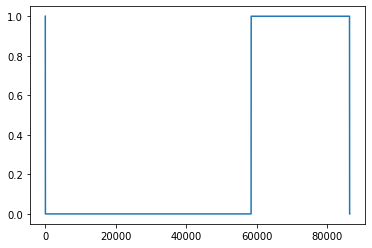

In [9]:
mg0_status = mg0._grid_status_ts
mg1_status = mg1._load_ts
print(len(mg1_status))
plt.plot(mg1_status[0:60])
plt.show()
plt.plot(mg0_status[0:DAY])
plt.show()

In [ ]:
mg0.get_control_dict()

In [ ]:
# Grid is up

    # PV is above load
        # Battery full
            # action 0: grid up, export, battery full, pv > load
        # Battery empty
            # action 1: grid up, charge w/ genset, battery empty, pv > load
        # Battery not at full charge
            # action 2: grid up, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 3: grid up, discharge, battery full, pv < load
        # Battery empty
            # action 4: grid up, import, battery empty, pv < load
                # import + charge until battery > 15%
        # Battery not at full charge
            # action 5: grid up, discharge, battery < full charge, pv < load
                # discharge if battery > 75 %
                # charge if battery < 15%

# Grid is down

    # PV is above load
        # Battery full
            # action 6: grid down, use pv, battery full, pv > load
        # Battery empty
            # action 7: grid down, charge w/ pv, battery empty, pv > load
        # Battery not at full charge
            # action 8: grid down, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 9: grid down, discharge, battery full, pv > load
        # Battery empty
            # action 10: grid down, genset, battery empty, pv > load
        # Battery not at full charge
            # action 11: grid down, discharge, battery < full, pv > load

# Stock control dict

# control_dict = {'pv_consummed': min(pv,load),
#                             'battery_charge': 0,
#                             'battery_discharge': 0,
#                             'grid_import': 0,
#                             'grid_export':0,
#                             'genset': 0
#                            }

def actions_agent(mg0, action):
 
    
    pv = round(mg0.pv)
    load = round(mg0.load)
    soc = round(mg0.battery.soc,2)
    capa_total = round(mg0.battery.capacity,2)
    p_charge_max = round(mg0.battery.p_charge_max,2)
    p_discharge_max = round(mg0.battery.p_discharge_max,2)

          
    if action == 0:
        # Grid is up
        # PV is above load
        # Battery full
        # action 0: grid up, export, battery full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': 0,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export':pv-abs(load),
                            'genset': 0
                        }

    elif action == 1:
        # Grid is up
        # PV is above load
        # Battery empty
        # action 1: grid up, charge w/ pv, battery empty, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': p_charge_max,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': pv-abs(load)-min(pv-load,p_charge_max),
                            'genset': 0
                        }

    elif action == 2:
        # Grid is up
        # PV is above load
        # Battery not at full charge
        # action 2: grid up, charge w/ pv, battery < full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': min(pv-load,p_charge_max),
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': pv-abs(load)-min(pv-load,p_charge_max),
                            'genset': 0
                        }

    
    elif action == 3:
        # Grid is up
        # PV is below load
        # Battery full
        # action 3: grid up, discharge, battery full, pv < load
        control_dict =  {   'pv_consummed': min(pv,abs(load)),
                            'battery_charge': 0,
                            'battery_discharge': min(abs(load), p_discharge_max),
                            'grid_import': abs(load) - p_discharge_max,
                            'grid_export': 0,
                            'genset': 0
                        }

    elif action == 4:
        # Grid is up
        # PV is bellow load
        # Battery empty
        # action 4: grid up, import, battery empty, pv < load
        # import + charge until battery > 15%
        control_dict =  {   'pv_consummed': min(pv,load),
                            'battery_charge': p_charge_max,
                            'battery_discharge': 0,
                            'grid_import': abs(load)+p_charge_max,
                            'grid_export': 0,
                            'genset': 0
                        }
    
    elif action == 5:
        # Grid is up
        # PV is bellow load
        # Battery not at full charge
        # action 5: grid up, discharge, battery < full charge, pv < load
        # discharge if battery > 75 %
        # charge if battery < 15%

        if soc > int(0.75*capa_total):
            # Discharge
            control_dict =  {   'pv_consummed': min(pv,load),
                                'battery_charge': 0,
                                'battery_discharge': p_discharge_max,
                                'grid_import': abs(load)-p_discharge_max,
                                'grid_export': 0,
                                'genset': 0
                            }
        
        elif soc < int(0.15*capa_total):
            # Charge
            control_dict =  {   'pv_consummed': min(pv,load),
                                'battery_charge': p_charge_max,
                                'battery_discharge': 0,
                                'grid_import': abs(load)+p_charge_max,
                                'grid_export': 0,
                                'genset': 0
                            }
    
    elif action == 6:
        # Grid is down
        # PV is above load
        # Battery full
        # action 6: grid down, use pv, battery full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': 0,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 0
                        }

    elif action == 7:
        # Grid is down
        # PV is above load
        # Battery empty
        # action 7: grid down, charge w/ pv, battery empty, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': min(pv-abs(load),p_charge_max),
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 0
                        }
    elif action == 8:
        # Grid is down
        # PV is above load
        # Battery not at full charge
        # action 8: grid down, charge w/ pv, battery < full, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': min(pv-abs(load),p_charge_max),
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 0
                        }
    elif action == 9:
        # Grid is down
        # PV is bellow load
        # Battery full
        # action 9: grid down, discharge, battery full, pv > load

        if p_discharge_max < load:
            #Turn genset on
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 1
                            }
        else:
            # Genset off
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 0
                            }

    elif action == 10:
        # Grid is down
        # PV is bellow load
        # Battery empty
        # action 10: grid down, genset, battery empty, pv > load
        control_dict =  {   'pv_consummed': abs(load),
                            'battery_charge': 0,
                            'battery_discharge': 0,
                            'grid_import': 0,
                            'grid_export': 0,
                            'genset': 1
                        }

    elif action == 11:
        # Grid is down
        # PV is bellow load
        # Battery not at full charge
        # action 11: grid down, discharge, battery < full, pv > load
        if p_discharge_max < load:
            #Turn genset on
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 1
                            }
        else:
            # Genset off
            control_dict =  {   'pv_consummed': pv,
                                'battery_charge': 0,
                                'battery_discharge': min(abs(load)-pv,p_discharge_max),
                                'grid_import': 0,
                                'grid_export': 0,
                                'genset': 0
                            }
    return control_dict

In [ ]:
def change_name_action(idx):
# Grid is up

    # PV is above load
        # Battery full
            # action 0: grid up, export, battery full, pv > load
        # Battery empty
            # action 1: grid up, charge w/ genset, battery empty, pv > load
        # Battery not at full charge
            # action 2: grid up, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 3: grid up, discharge, battery full, pv < load
        # Battery empty
            # action 4: grid up, import, battery empty, pv < load
                # import + charge until battery > 15%
        # Battery not at full charge
            # action 5: grid up, discharge, battery < full charge, pv < load
                # discharge if battery > 75 %
                # charge if battery < 15%

# Grid is down

    # PV is above load
        # Battery full
            # action 6: grid down, use pv, battery full, pv > load
        # Battery empty
            # action 7: grid down, charge w/ pv, battery empty, pv > load
        # Battery not at full charge
            # action 8: grid down, charge w/ pv, battery < full, pv > load

    # PV is below load
        # Battery full
            # action 9: grid down, discharge, battery full, pv > load
        # Battery empty
            # action 10: grid down, genset, battery empty, pv > load
        # Battery not at full charge
            # action 11: grid down, discharge, battery < full, pv > load

    if idx == 0:
        action_name = "grid up, export, battery full, pv > load"
    elif idx == 1:
        action_name = "grid up, charge w/ genset, battery empty, pv > load"
    elif idx == 2:
        action_name = "grid up, charge w/ pv, battery < full, pv > load"
    elif idx == 3:
        action_name = "grid up, discharge, battery full, pv < load"
    elif idx == 4:
        action_name = "grid up, import, battery empty, pv < load"
    elif idx == 5:
        action_name = "grid up, discharge, battery < full charge, pv < load"
    elif idx == 6 :
        action_name = "grid down, use pv, battery full, pv > load"
    elif idx == 7 :
        action_name = "grid down, charge w/ pv, battery empty, pv > load"
    elif idx == 8 :
        action_name = "grid down, charge w/ pv, battery < full, pv > load"
    elif idx == 9 :
        action_name = "grid down, discharge, battery full, pv > load"
    elif idx == 10 :
        action_name = "grid down, genset, battery empty, pv > load"
    elif idx == 11 :
        action_name = "grid down, discharge, battery < full, pv > load"
    return action_name

In [ ]:
def init_qtable(mg0, nb_action):
    cover_rate = (mg0._pv_ts*100)/mg0._load_ts
    state = []
    Q = {}
    cover_rate_range = np.arange(int(cover_rate.min()),int(cover_rate.max()))
    soc_range = np.arange(round(mg0.battery.soc_min,1),round(mg0.battery.soc_max+0.1,1),0.1)
    for i in cover_rate_range:
        for j in soc_range:
            j = round(j,1)
            state.append((i,j))
    
    # Initialize Q(s,a) at zero
        for s in state:
            Q[s] = {}
            for a in range(nb_action):
                Q[s][a] = 0
    return Q

I define a function for my exploration strategy. Here I've selected the epsilon greedy decreasing strategy

In [ ]:
def espilon_decreasing_greedy(action, epsilon, nb_action):
    
    p = np.random.random()

    if p < (1 - epsilon):
        randomm=0
        return action, randomm

    else: 
        randomm=1
        return np.random.choice(nb_action), randomm

In [ ]:
def max_dict(d):

    max_key = None
    max_val = float('-inf')


    for k,v in d.items():

        if v > max_val:

            max_val = v
            max_key = k

    return max_key, max_val

I also need to define a function to decrease and update my espilon 

In [ ]:
def update_epsilon(epsilon):
    
    epsilon = epsilon - epsilon *0.02
    
    if epsilon < 0.1:
        
        epsilon = 0.1
    
    return epsilon

In [ ]:
def print_welcome(idx):
    
    if idx == 0:
        print("------------------------------------")
        print("|        WELCOME TO PYMGRID        |")
        print("------------------------------------")
    elif idx == 1:
        
        print("t -     STATE  -  ACTION - COST")
        print("================================")
    

Now I define my agent function

In [ ]:
def training_Q_Learning(mg,horizon):
    
    nb_action = 12
    Q = init_qtable(mg,nb_action)
    nb_state = len(Q)
    nb_episode = 1000
    alpha = 0.1
    epsilon = 0.99
    gamma = 0.99
    
    record_cost = []
    t0 = time.time()
    t = t0
    print_training = "Training Progressing .   "
    print_welcome(0)
    print("\n")
    for e in range(nb_episode+1):
        
        if e == 0:
            value_print="\rEpisode " + str(e) +"/" + str(nb_episode)
            sys.stdout.write(value_print)
            sys.stdout.flush()
        
        else:
            
            now = time.time()
            
            if e == 1 or e == 50 or e == 100 or e == 200 or e == 300 or e == 400  or e == 450  or e == 485 or e == nb_episode-5:
                diff_time_t = now - t 
                total_time = (nb_episode+1) * diff_time_t
            
            now = time.time()
            
            diff_time = now - t0
            time_remaining = total_time - diff_time
            
            t = time.time()
        
        if e % 10 == 0:
        
            if print_training == "Training Progressing .   ":
                
                print_training = "Training Progressing ..  "
                
            elif print_training == "Training Progressing ..  ":
            
                print_training = "Training Progressing ... "
            
            else:
                
                print_training = "Training Progressing .   "

        value_print="\r"+ print_training +"Episode " + str(e) +"/" + str(nb_episode) 
        sys.stdout.write(value_print)
        sys.stdout.flush()
            
        episode_cost = 0
        mg.reset()
        
        cover_rate = (mg.pv*100)/mg.load
        soc = round(mg.battery.soc,1)
        s = (cover_rate, soc)
        
        a = max_dict(Q[s])[0]
        a,randomm = espilon_decreasing_greedy(a, epsilon, nb_action)
        for i in range (horizon):
            action = actions_agent(mg,a)

            action_name = change_name_action(a)
            status = mg.run(action)
            r = -mg.get_cost() 
            episode_cost += mg.get_cost()/3600
            cover_rate = (mg.pv*100)/mg.load
            soc = round(mg.battery.soc,1)
            s_ = (cover_rate, soc)
            a_ = max_dict(Q[s_])[0]
            if i == horizon-1:
                Q[s][a] += alpha*(r - Q[s][a])
            else:
             
                old_Q = Q[s][a]
                target = r + gamma*Q[s_][a_]
                td_error = target - Q[s][a]
                Q[s][a] = (1-alpha) * Q[s][a] + alpha * td_error
                
            s, a = s_, a_
       
        epsilon = update_epsilon(epsilon)
        
    return Q

In [ ]:
def testing_Q_Learning(mg, Q,horizon):
    cost_record = np.array((1,))
    mg.reset()
    cover_rate = (mg.pv*100)/mg.load
    soc = round(mg.battery.soc,1)
    s = (cover_rate, soc)
    a = max_dict(Q[s])[0]
    total_cost = 0
    print_welcome(1)
    export_counter = 0
    for i in range (1,horizon):

        action_name = change_name_action(a)
        action = actions_agent(mg, a)
        if action == 0:
            export_counter += 1
        status = mg.run(action)
        # display(status) 
        cost = mg.get_cost()/3600
        cost_record = np.append(cost_record, cost+cost_record[i-1])
        total_cost += cost
        if i < 10:
            print(i," -",(int(cover_rate),soc),action_name, round(total_cost,2), "€")
        else:
            print(i,"-",(int(cover_rate),soc),action_name, round(total_cost,2), "€")
        cover_rate = (mg.pv*100)/mg.load
        soc = round(mg.battery.soc,1)
        s_ = (cover_rate, soc)
        a_ = max_dict(Q[s_])[0]

        s, a = s_, a_
    return cost_record,export_counter

In [ ]:
Q1 = training_Q_Learning(mg1,60)

In [ ]:
cost_record,export_counter = testing_Q_Learning(mg0,Q1, 10000)

In [ ]:
print(export_counter)

In [ ]:
df_cost_record = pd.DataFrame(cost_record)
print(cost_record[60])
plt.plot(df_cost_record[0:60], linestyle='dotted',
         label='line1', linewidth=1)
plt.show()